# Ecuaciones de modelo SIR

## 0) Introducción y planteamiento

### Introducción:

Vamos a intentar ahora realizar un ajuste a la curva de contagios de España de las ecuaciones paramétricas del modelo SIR:

Las variables serán:

x -> población sana
y -> infectados
z -> recuperados 

Decir que "recuperados" es un nombre un poco desafortunado por parte del modelo, que no contempla mortalidad, de forma que en recuperados se englobal tanto las altas como los fallecimientos (gente que ya no tiene el virus pero que no puede ya ser contagiada).

El modelo de ecuaciones diferenciales es el siguiente:

$ x' = -\beta x y $

$ y' = \beta x y -\gamma y $

$ z' = \gamma y $

Con condiciones:

$ x_(t=0) = N1 $

$ y_(t=0) = N2 $

$ z_(t=0) = N3 $

$ N1 + N2 + N3 = N $

Decir que $\beta$ en este caso equivale a $\beta \cdot N$ en otras notaciones (por ejemplo, las empleadas aquí: https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_without_vital_dynamics), donde $e^{\beta}$ sería el factor de reproducción de la enfermedad.

La resolución de las ecuaciones puede encontrarse en:

https://arxiv.org/pdf/1403.2160.pdf

La solución, en función del paramétro u, es la siguiente:

$ x = x_0 \cdot u $

$ y = A \cdot ln(u) - x_0 \cdot u + N $

$ z = -  A \cdot ln(u) $

Donde:

$ A = \gamma / \beta $

$ x_0 = \frac {N1}{u_0} $

$ u_0 = e^{-N3/A} $

Y:

$ t - t_0 = \frac{1}{\beta} \cdot \int_{1}^{u} \frac{1}{u* y(u*)} du* $

De estas ecuaciones, sin introducir resultados, podemos extraer algunas conclusiones:

$u_0$ nos da la fracción de personas sanas en la población sobre el total, en el momento  referencia.

Es necesario que: $ N >= x_0 $, lo que implica: $ N >= N/u_0 $ para que en t = 0 exista un numero mayor o igual que 0 de infectados.

La ecuación en y tiene un límite en u, a partir del cual, comienza a decrecer. Derivando, tendremos:

$ y' = A/ u_l - x_0 = 0 $

De donde:

$ u_l = A/x_0 $

Y en el límite, por lo tanto:

$ x_0 = A $

El rango de definición para la u será, por lo tanto $ u -> (1, 0) $, con el pico de infectados produciéndose en $u_l = A/x_0$.

### Planteamiento:

**Primera parte:**

Como se puede ver, las ecuaciones están resueltas en un parámetro externo, y no en función del tiempo.

Además, no es posible obtener una relación:

$ u = u(t) $

de manera explícita, sino al contrario, lo que dificulta el proceso del ajuste, ya que no disponemos de las $u(t)$ que introducir en las ecuaciones anteriores.

Lo que nos proponemos, por lo tanto, es aprovechar una relación implícita, para calibrar unos primeros parámetros, relacionando $y(u)$ y $z(u)$ para obtener $y(z)$.

En efecto, si despejamos de las ecuaciones más arriba tendremos que:

$ y(z) = -z - x_0 \cdot e^{-z/A} + N $

Y eliminando $x_0$:

$ y(z) = -z - N1 \cdot e^{-(z - N3)/A} + N $

Ajustaremos primeramente, por lo tanto los parámetros A, N, N1, N3 de $y(z)$.

A priori, parecería que estaría todo resuelto.

El problema, sin embargo, seguimos sin disponer de marco temporal. No sólo eso, sino que nuestro ajuste se está dando para unos valores de u(t) que no tienen por qué coincidir con los valores reales de t para dichas observaciones.

Obtendremos por lo tanto u haciendo:

$ u = e^{-z/A} $

Ahora, para llegar a calcular los tiempos tendríamos que hacer:

$ t - t_0 = \frac{1}{\beta} \cdot \int_{1}^{u} \frac{1}{u* y(u*)} du* $

$t_0$ podemos despreciarlo, si tomamos como origen el momento en el que $ u =1 $.

En donde aún tendríamos que determinar $\beta$.

Llamando:

$ f(u) =  \frac{1}{u* y(u*)} $

Haremos:

$ p  = \int_{1}^{u} f(u*) du* $

Y haremos un ajuste por mínimos cuadrados para obtener el $beta$ que hace que $ t - \beta \cdot p $ sea mínimo.

(PD: como se puede ver, entonces, la forma de la curva de contagios no depende del parámetro $\beta$, sino solamente de la relación $\gamma / \beta$, siendo el papel de $\beta$ el de ajustar la distribución temporalmente)

**Segunda parte:**

Hasta el paso anterior, tendríamos el problema del ajuste resuelto, pero como se puede observar, los tiempos obtenidos no se ajustan a los tiempos de las observaciones de nuestros datos.

Por lo tanto, puede que el ajuste de las curvas sea bueno, pero no lo será su ajuste en el tiempo.

Por lo tanto, resolveremos este problema realizando un proceso en bucle.

Una vez obtenidos los coeficientes, $\beta$, A, N, N1 y N3, crearemos un registro con un paso lo suficientemente pequeño, de la relación u - t existente, obteniendo ya un $u$ para cada uno de nuestros $t$ (ahora sí, reales).

Ahora sí, haremos un ajuste de los coeficientes por mínimos cuadrados de $y(u)$, obteniendo unos nuevos coeficientes A, N, N1, N3, con los que volveremos a calcular la integral y ajustar por mínimos cuadrados para obtener un nuevo $\beta$.

Realizaremos el proceso en bucle unas cuantas veces para intentar obtener convergencia (veremos que no existe).

**Fin:**

Compararemos entonces los resultados obtenidos con el ajuste de la primera parte con los obtenidos por el ajuste obtenido por la segunda y sacaremos conclusiones.

## 1) Carga de datos

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import leastsq
from scipy.optimize import least_squares
from scipy.integrate import simps

%matplotlib inline

from IPython.display import display
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
ruta = 'Datos/Contagios medios coronavirus RTVE.csv'
sep = ';'

date_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')

datos = pd.read_csv(ruta, sep = sep, index_col = 'FECHA', parse_dates = ['FECHA'], date_parser = date_parser)
# datos = datos.loc[:'2020-04-08', :]


datos['DIFER_DIAS'] = datos.index.to_series().diff().fillna(pd.Timedelta(seconds = 8660000)).apply(lambda x: x.days)

datos['CONT_DIARIOS'] = (datos['CONTAGIOS'].diff(1).fillna(0)/datos['DIFER_DIAS'])
datos['M_DIARIOS'] = (datos['MUERTOS'].diff(1).fillna(0)/datos['DIFER_DIAS'])
datos['ALTAS_DIARIAS'] = (datos['ALTAS'].diff(1).fillna(0)/datos['DIFER_DIAS'])

index_for_merge = pd.DataFrame(index = pd.date_range(datos.index[0], datos.index[-1]))

# Creamos un dataframe con todas las fechas para ambas series, y rellenamos los NaN con el último dato inmediatamente anterior:

datos_full_index = pd.merge(index_for_merge, datos, left_index= True, right_index= True, how='left')

datos_full_index[['CONT_DIARIOS', 'M_DIARIOS', 'ALTAS_DIARIAS']] = datos_full_index[['CONT_DIARIOS', 'M_DIARIOS', 'ALTAS_DIARIAS']].fillna(method = 'backfill')

datos_full_index['MARCA'] = datos_full_index['CONTAGIOS'].apply(lambda x: 0 if x > 0 else 1)

datos_full_index.loc[datos_full_index['MARCA'] == 1, ['CONT_DIARIOS', 'M_DIARIOS', 'ALTAS_DIARIAS']] = datos_full_index.loc[datos_full_index['MARCA'] == 1, ['CONT_DIARIOS', 'M_DIARIOS', 'ALTAS_DIARIAS']].cumsum()


datos_full_index[['CONTAGIOS','MUERTOS', 'ALTAS']] = datos_full_index[['CONTAGIOS','MUERTOS', 'ALTAS']].fillna(method = 'ffill')
datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONTAGIOS'] = datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONTAGIOS'] + datos_full_index.loc[datos_full_index['MARCA'] == 1, 'CONT_DIARIOS']
datos_full_index.loc[datos_full_index['MARCA'] == 1, 'MUERTOS'] = datos_full_index.loc[datos_full_index['MARCA'] == 1, 'MUERTOS'] + datos_full_index.loc[datos_full_index['MARCA'] == 1, 'M_DIARIOS']
datos_full_index.loc[datos_full_index['MARCA'] == 1, 'ALTAS'] = datos_full_index.loc[datos_full_index['MARCA'] == 1, 'ALTAS'] + datos_full_index.loc[datos_full_index['MARCA'] == 1, 'ALTAS_DIARIAS']

datos_full_index['CONTAGIOS'] = datos_full_index['CONTAGIOS'].astype('int')
datos_full_index['MUERTOS'] = datos_full_index['MUERTOS'].astype('int')
datos_full_index['ALTAS'] = datos_full_index['ALTAS'].astype('int')

datos_full_index['R'] = datos_full_index['MUERTOS'] + datos_full_index['ALTAS']
datos_full_index['I'] = datos_full_index['CONTAGIOS'] - datos_full_index['R']

datos_full_index = datos_full_index[['CONTAGIOS', 'MUERTOS', 'ALTAS', 'R', 'I']]

datos_full_index[['C_DIA', 'M_DIA', 'A_DIA', 'R_DIA', 'I_DIA']] = datos_full_index[['CONTAGIOS', 'MUERTOS', 'ALTAS', 'R', 'I']].diff(1).fillna(0).astype(int)

datos_full_index = datos_full_index['2020-03-12':]

Estos serán las series protagonistas de nuestro modelo:

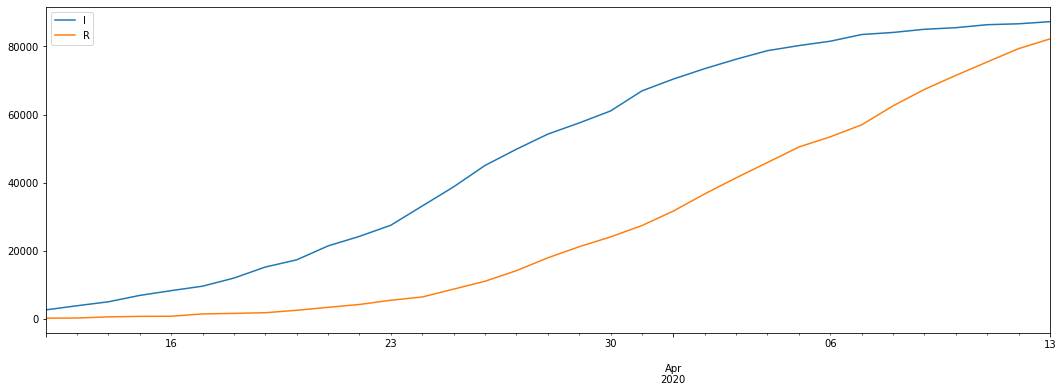

In [4]:
datos_full_index[['I', 'R']].plot();

Y, en concreto, empezaremos modelando la relación:

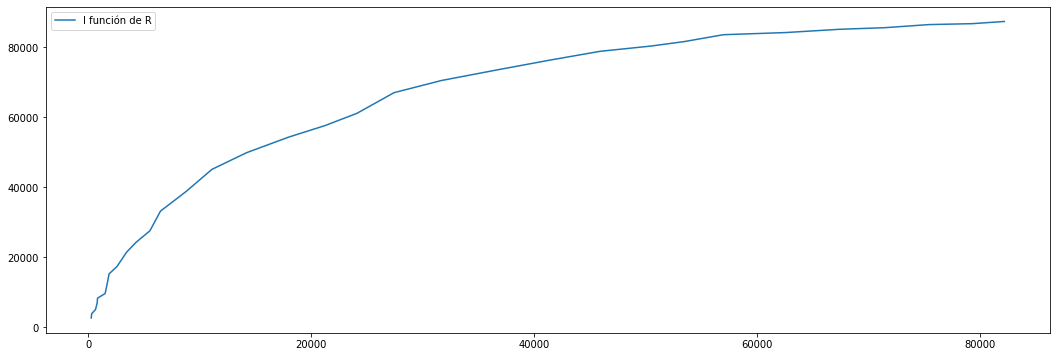

In [5]:
plt.plot(datos_full_index['R'], datos_full_index['I'], label = 'I función de R')
plt.legend();

## 2) Aplicación de ecuaciones del modelo

Definimos primero unas cuantas funciones que emplearemos en el bucle a continuación:

In [6]:
# Función de error para ajuste por mínimos cuadrados de y(z):

def error_y(variab, z, y, weights):
    
    A, N, N1, N3 = variab
    
    y_est = -z - N1 * np.exp(-(z - N3) / A) + N

    aux = list(y_est[y_est < 0])
    
    if y_est[0] > 4000:
        
        return weights * (y - y_est)
    
    else:
        
        return np.ones(len(y_est)) * 99999

In [7]:
# Función de error para ajuste por mínimos cuadrados de y(u):

def error_y_de_u(variab, u, y, weights):
    
    A, N, N1, N3 = variab
    
    y_est = A * np.log(u) - N1 * u * np.exp(N3 / A) + N
    
    aux = list(y_est[y_est < 0])
    
    if y_est[0] > 4000:
        
        return weights * (y - y_est)
    
    else:
        
        return np.ones(len(y_est)) * 99999

In [8]:
# Función auxiliar para integrar por método de Simmpson:

def integral(x):
    
    prov = datos_full_index[datos_full_index['u'] >= x]

    return simps(prov['f'], prov['u']) 

In [9]:
# Función auxiliar para integrar por método de Simmpson en DataFrame de relación u(t):

def integral_reg_u(x):
    
    prov = df_reg_u[df_reg_u['u'] >= x]

    return simps(prov['f'], prov['u']) 

In [10]:
def error_t(variab, inte, t, weights):

    beta = variab

    return weights * (t - 1/beta * inte)

Y, a continuación, comentado, el bucle que hace todo lo descrito en la introducción:

In [11]:
# Algunos parámetros inciales y variables de memoria de resultados:

iteraciones = 10

weights = np.ones(datos_full_index.shape[0])
datos_full_index['DIA'] = list(range(0, datos_full_index.shape[0]))

coefs_m = np.array([0.,0.,0.,0.])
beta_m = 0

# Bucle:

for i in range(iteraciones):
    
    print(i)
    
    # En un primer paso, hace el ajuste de y(z):

    if i == 0:

        vas = [50000, 180000, 80000, 36000]
        bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

        sal = least_squares(error_y, vas, args=(datos_full_index['R'], datos_full_index['I'], weights), bounds = bounds)

        # Guardamos algunos valores por separado según respondan al ajuste por y(z) o y(u):
        
        coefs_i_1 = sal.x

        z = datos_full_index['R']

        A, N, N1, N3 = coefs_i_1
        y_est_1 = -z - N1 * np.exp(-(z - N3) / A) + N
        
        print(coefs_i_1.round())
        print (y_est_1.max(), y_est_1[-1])
        
    # En el resto, hace el ajuste de y(u):

    else:

        vas = coefs_i_1
        bounds = ([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf])

        x = np.array(nuevos_puntos)
        y = np.array(datos_full_index['I'])

        sal = least_squares(error_y_de_u, vas, args=(x, y, weights), bounds = bounds)
        
        # Guardamos algunos valores por separado según respondan al ajuste por y(z) o y(u):

        coefs_i_2 = sal.x

        A, N, N1, N3 = coefs_i_2

        y_est_2 = A * np.log(x) - N1 * x * np.exp(N3 / A) + N
        
        print(coefs_i_2.round())
        print (y_est_2.max(), y_est_2[-1])
        
        coefs_m += coefs_i_2

    # Guardamos otros resultados de la optimización:
        
    coste = sal.cost
    res = sal.fun
    opt = sal.optimality
    
    # Imprimimos valores para comprobar los resultados de la misma:

    print(res.mean(), abs(res).mean())

    # Calculamos ya algunos parámetros del modelo (tal vez lo borre en un futuro):
    
    N2 = N - N1 - N3
    u0 = np.exp(-N3/A)
    x0 = N1/ u0
    N20 = N - x0
    u_lim = A/x0
    z_lim = -A * np.log(u_lim)
    y_lim = -z_lim - N1 * np.exp(-(z_lim - N3) / A) + N
    
    # Imprimimos el valor de y_lim para compararlo con el del máximo y el último de nuestro ajuste:
    
    print(y_lim)
    
    # Guardamos los valores de las distintas estimaciones realizadas. También calculamos u en función del caso en el que
    # nos encontramos:
    
    if i == 0:

        datos_full_index['I_EST_' + str(i+1)] = y_est_1
        datos_full_index['u'] = np.exp(-datos_full_index['R']/A)
        
    else:
        
        datos_full_index['I_EST_' + str(i+1)] = y_est_2
        datos_full_index['u'] = np.array(nuevos_puntos)  
        
    # Calculamos la función para integrar y la integramos, empleando la función auxiliar definida más arriba:
    
    datos_full_index['f'] = 1/(datos_full_index['u'] * ( -N -A * np.log(datos_full_index['u']) + N1/u0 * datos_full_index['u']))
    
#     datos_full_index['f'] = - 1/(datos_full_index['u'] * datos_full_index['I_EST_' + str(i+1)])
    datos_full_index['int'] = datos_full_index['u'].apply(integral)
    
    # Damos valores iniciales y realizamos el segundo ajuste:
    if i == 0:
        vas_2 = [0.0003]
    else:
        vas_2 = beta
        
    bounds_2 = (0, 1)

    sal_2 = least_squares(error_t, vas_2, args=(datos_full_index['int'], datos_full_index['DIA'], weights), bounds = bounds_2)

    # Obtenemos beta, que guardamos, imprimimos y metemos en una variable que medirá valores medios:
    
    beta = sal_2.x[0]
    print(beta)
    
    # Guardamos por separado la beta del primer método:
    
    if i == 0:
        
        beta0 = beta
        
    else:
        
        beta_m += beta
    
    # Reajustamos f y la integral con los betas obtenidos:

#     datos_full_index['f'] = 1/beta * datos_full_index['f']
#     datos_full_index['int'] = 1/beta * datos_full_index['int']
    
#     beta = beta *( 0.9 * datos_full_index['int'][-1]/datos_full_index['DIA'][-1])
    
    # Creamos ahora un dataframe auxiliar con un u de paso fino, para obtener u(t):
    
    # Creamos el array de u y lo guardamos en un DataFrame:
    
    print(datos_full_index['u'].max())

    u_range = np.arange(datos_full_index['u'].max(), 0.0, - datos_full_index['u'].diff(1).abs().min()/10, dtype = np.float64)
    
    
#     aux = np.linspace(8, -8, 1000)
#     u_range = 1/(np.exp(-aux) + 1)
#     u_range = u_range[u_range <= datos_full_index['u'].max()]
#     u_range[0] = datos_full_index['u'].max()
    
    df_reg_u = pd.DataFrame(u_range, columns = ['u'], dtype = np.float64)
    
    # Calculamos con nuestros parámetros f y la integral:
    df_reg_u['y'] = A * np.log(df_reg_u['u']) - N1 * df_reg_u['u'] * np.exp(N3 / A) + N
    df_reg_u['z'] = - A * np.log(df_reg_u['u'])
    df_reg_u['tot_infectados'] = df_reg_u['y'] + df_reg_u['z']
    df_reg_u['f'] = 1/beta * (1/(df_reg_u['u'] * ( -N -A * np.log(df_reg_u['u']) + N1/u0 * df_reg_u['u'])))
#     df_reg_u['f'] = - 1/beta * (1/(df_reg_u['u'] * df_reg_u['y']))
    df_reg_u['int'] = df_reg_u['u'].apply(integral_reg_u)
    
    df_reg_u = df_reg_u[df_reg_u['y'] >= 0]
    
    # Nos quedamos con la parte entera de la integral, el mínimo para cada una será el valor que más se ajusta al propio entero.
    
    # Por ejemplo, habrá varios valores de la integral: 1.083, 1.223, 1.579, 1.892... el que más se parece al 1 
    # será el primero de ellos. Hacemos eso para todos los valores del rango de nuestras fechas, y filtramos para quedarnos sólo
    # estos valores:
    
    df_reg_u['marca'] = df_reg_u['int'].astype(int)

    filtro = df_reg_u[df_reg_u['marca'] <= datos_full_index['DIA'].max()].groupby('marca')['int'].min()
    
    # Tenemos finalmente entonces estos valores, que entrarán en la segunda iteración del bucle y siguientes, para calcular
    # el ajuste ahora de y(u):

    nuevos_puntos = df_reg_u[df_reg_u['int'].isin(filtro)][['u', 'marca']].set_index('marca')['u']
    
    # Si u no permite la creación de un rango de valores apropiado, lo advertimos y salimos:
    
    if i < iteraciones - 1 and nuevos_puntos.index.max() != datos_full_index['DIA'].max():
        
        print ('\niteración', i, ':' , 'problema en el rango de u')
        
        break
                                                                         
    elif i < iteraciones -1  and len(nuevos_puntos.index) !=  len(datos_full_index['DIA']):

        print ('\niteración', i, ':' , 'los arrays no tienen las mismas dimesiones')
        
        break    
    
    print('\n')
    
coefs_m = coefs_m/i
beta_m = beta_m/i

0
[ 43053. 191418.  79702.  35944.]
85906.55150772835 81994.01765818923
-0.003377846364993743 3018.7389211786303
85906.71115113603
1.0567367006775852e-06
0.9936790356504736


1
[ 42420. 192111.  97497.  28087.]
86269.89008730312 84332.5094345864
-2045.6684797010055 2340.6304191970034
86301.27110904029
1.2827344969794598e-06
0.9936790356504736


2
[ 39427. 186438.  66703.  39589.]
86649.92410183093 82862.19825743354
-0.016905273718293756 1813.601269954416
86690.8713830309
1.2138650750199864e-06
0.9936790356504736


3
[ 42009. 190608.  79702.  35944.]
85709.66844693292 81854.20083574914
-82.6539430026958 1387.7045770385655
85752.43606708045
1.29301108783332e-06
0.9936790356504736


4
[ 38829. 185244.  72120.  35709.]
86630.21032344233 82887.76982219504
-0.014971714281163066 1793.8874489854018
86664.48643120826
1.2219280647911254e-06
0.9936790356504736


5
[ 42019. 190570.  79702.  35944.]
85652.59080033755 81670.6202984159
-114.48218908569481 1404.4212493592415
85708.02618671035
1.296320

## 3) Visualización de resultados y comparación de parámetros

### 3.1) Visualizaciones

Como podemos ver a continuación, como resultado de las iteraciones anteriores hemos podido alisar la forma de la curva, un tanto basta, que nos aparecía al principio, así como hemos podido hacer converger los valores de los parámetros del modelo:

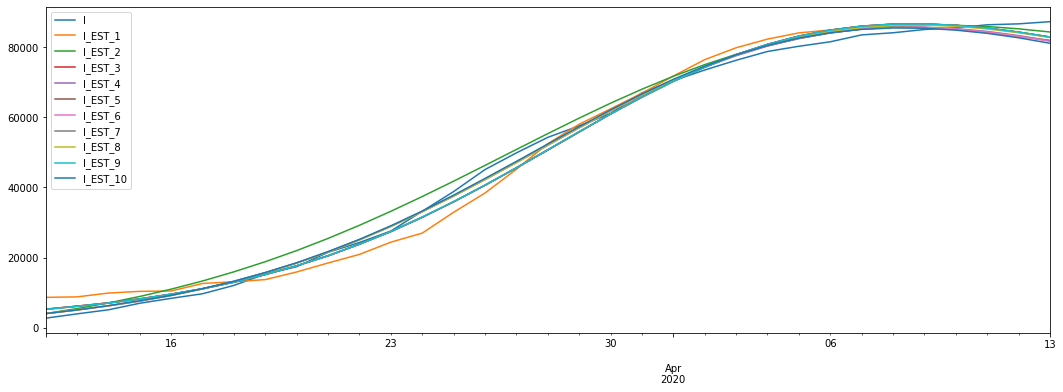

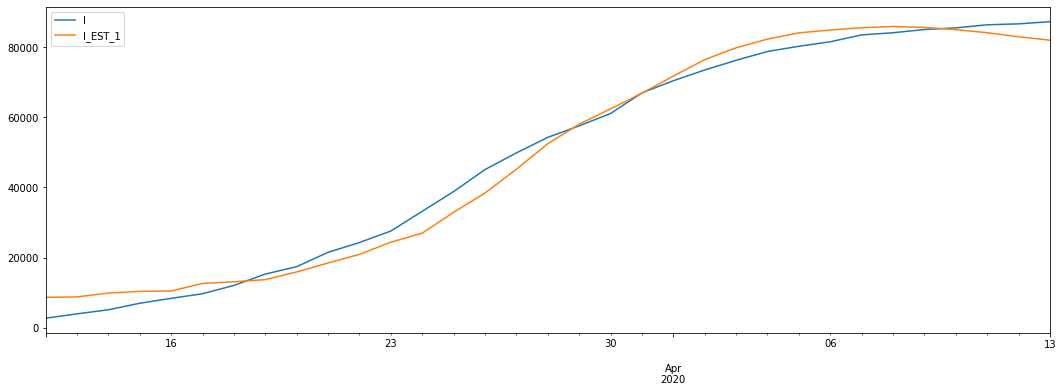

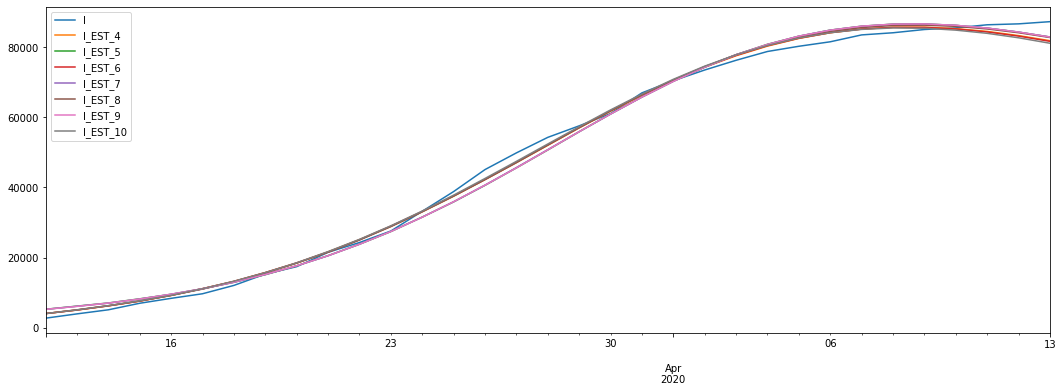

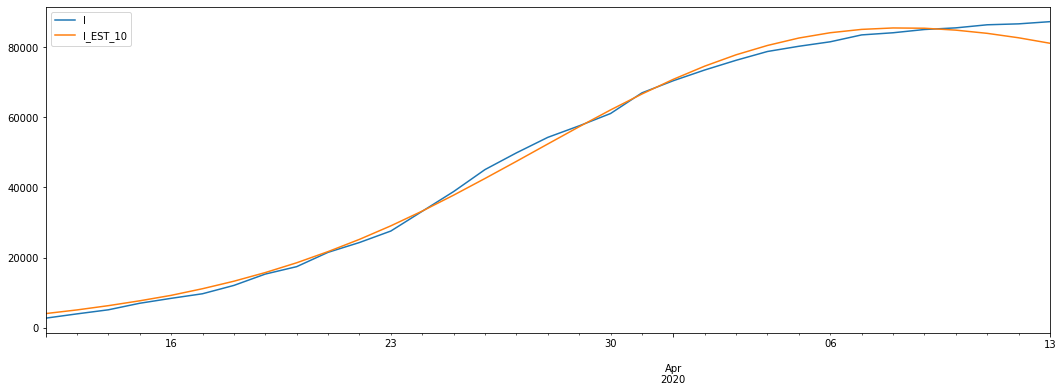

In [12]:
lista = list('I')

for element in datos_full_index.columns:
    
    if element.startswith('I_EST'):
        
        lista.append(element)
        
datos_full_index[lista].plot()

datos_full_index[lista[:2]].plot()
        
datos_full_index[['I'] + lista[4:]].plot()

datos_full_index[['I', 'I_EST_10']].plot()

Para los contagiados totales tendremos:

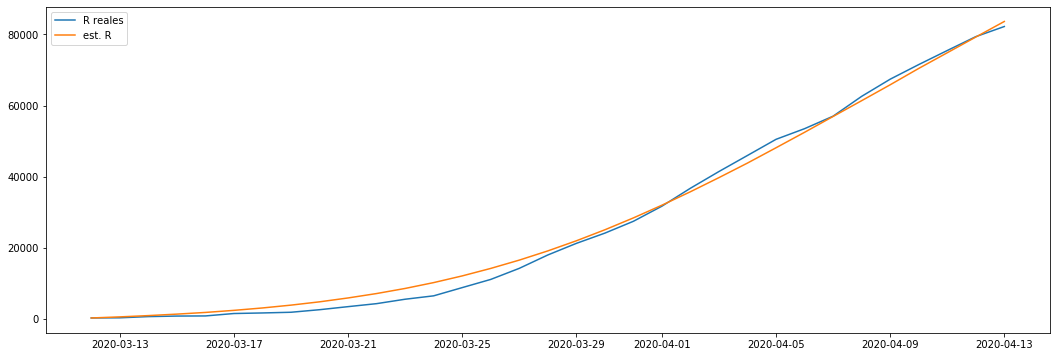

In [13]:
datos_full_index['R_EST'] = -A * np.log(datos_full_index['u'])
datos_full_index['CONTAGIOS_EST'] = datos_full_index['I_EST_10'] + datos_full_index['R_EST']

plt.plot(datos_full_index.index, datos_full_index['R'], label = 'R reales')
plt.plot(datos_full_index.index, datos_full_index['R_EST'], label = 'est. R')
plt.legend();

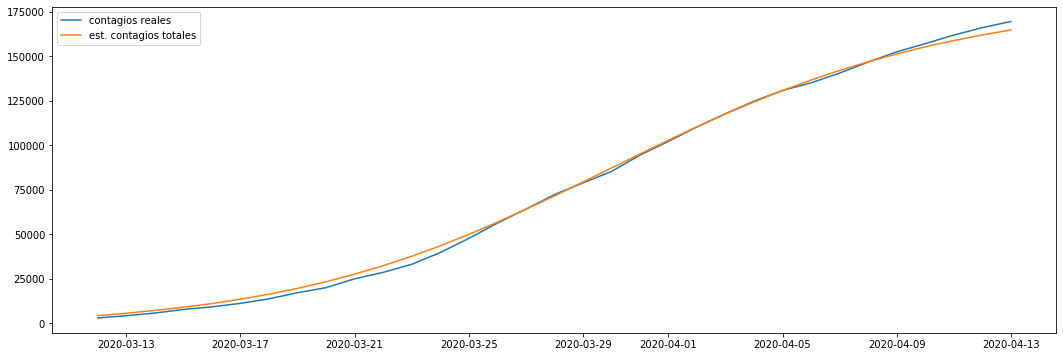

In [14]:
plt.plot(datos_full_index.index, datos_full_index['CONTAGIOS'], label = 'contagios reales')
plt.plot(datos_full_index.index, datos_full_index['CONTAGIOS_EST'], label = 'est. contagios totales')
plt.legend();

Respecto a la relación I(R) con la que hemos comenzado nuestras iteraciones, tendremos ahora:

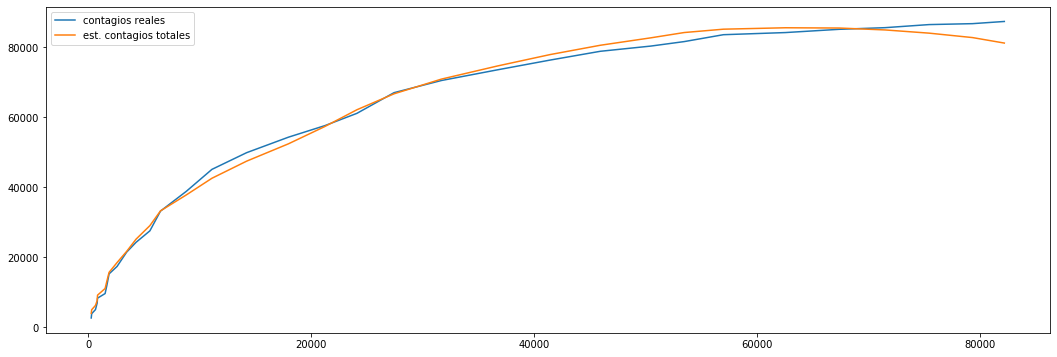

In [15]:
plt.plot(datos_full_index['R'], datos_full_index['I'], label = 'contagios reales')
plt.plot(datos_full_index['R'], datos_full_index['I_EST_10'], label = 'est. contagios totales')
plt.legend();

### 3.2) Comparación de parámetros

Vamos ahora a comparar los valores de los resultados empleando el ajuste y(u), comparando los valores medios almacenados con los de la última realización:

In [20]:
A_m, N_m, N1_m, N3_m = coefs_m
A_0, N_0, N1_0, N3_0 = coefs_i_1

gamma = A * beta
gamma_m = A_m * beta_m

In [17]:
print(coefs_i_1.round())
print(coefs_i_2.round())
print(coefs_m.round())

[ 43053. 191418.  79702.  35944.]
[ 42064. 190401.  79702.  35944.]
[ 40316. 187795.  80562.  33833.]


In [18]:
print(beta0)
print(beta)
print(beta_m)

1.0567367006775852e-06
1.3040188293731211e-06
1.264195414587006e-06


In [21]:
print(beta0 * N_0)
print(beta * N)
print(beta_m * N_m)

0.20227882905569622
0.24828662936179713
0.2374097251557531


In [22]:
N2 = N - N1 - N3
print(N2.round())
print(N3.round())
print(u0)

74755.0
35944.0
0.42548953048768445


In [23]:
datos_full_index.loc['2020-03-31',['I', 'R', 'u']]

I   66,969.0000
R   27,448.0000
u        0.5091
Name: 2020-03-31 00:00:00, dtype: float64

In [24]:
print('gamma:', gamma, '\ngamma_med:', gamma_m)
print('beta:', beta * N, '\nbeta_med:', beta_m * N_m)
print('factor de crecimiento:', np.exp(beta * N), '\nfactor de crecimiento_med:', np.exp(beta_m * N_m))

gamma: 0.054851723009982103 
gamma_med: 0.05096790801158563
beta: 0.24828662936179713 
beta_med: 0.2374097251557531
factor de crecimiento: 1.281827288881646 
factor de crecimiento_med: 1.267960526684854


In [25]:
print('valores en punto u0:\n')
print('u0:', u0.round(4))
print('N1:', N1.round())
print('N2:', N2.round())
print('N3:', N3.round())

valores en punto u0:

u0: 0.4255
N1: 79702.0
N2: 74755.0
N3: 35944.0


In [26]:
datos_full_index.loc['2020-04-02', ['u', 'I', 'R']]

u        0.4273
I   73,492.0000
R   36,746.0000
Name: 2020-04-02 00:00:00, dtype: float64

In [27]:
u_t_0 = datos_full_index.loc[datos_full_index.index[0], 'u']

print('valores iniciales:')
print('x0:', x0)
print('N20:', N20)
print('N30:', -A * np.log(u_t_0))

valores iniciales:
x0: 187318.40254219927
N20: 3082.7049948411004
N30: 266.7263742770635


In [28]:
datos_full_index.loc[datos_full_index.index[0], ['u', 'I', 'R']]

u       0.9937
I   2,692.0000
R     273.0000
Name: 2020-03-12 00:00:00, dtype: float64

In [29]:
print('valores en punto de inflexión:\n')
print('u lim:', u_lim)
print('y lim:', y_lim)
print('z lim:', z_lim)
print('contagios:', y_lim + z_lim)

valores en punto de inflexión:

u lim: 0.22455667358637477
y lim: 85510.17866917365
z lim: 62827.331491476936
contagios: 148337.5101606506


In [30]:
datos_full_index.loc['2020-04-08', ['u', 'I', 'R']]

u        0.2325
I   84,114.0000
R   62,576.0000
Name: 2020-04-08 00:00:00, dtype: float64

## 4) Predicciones

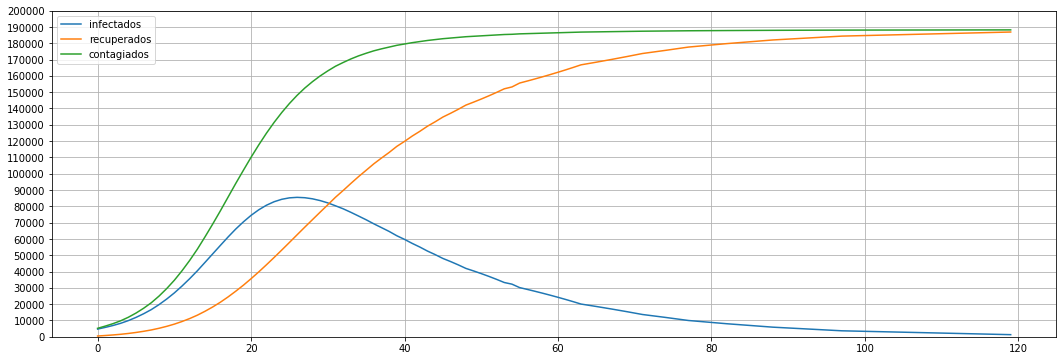

In [31]:
df_reg_u_red = df_reg_u[df_reg_u['int'].isin(df_reg_u.groupby(['marca'])['int'].max())]

plt.plot(df_reg_u_red['marca'], df_reg_u_red['y'], label = 'infectados')
plt.plot(df_reg_u_red['marca'], df_reg_u_red['z'], label = 'recuperados')
plt.plot(df_reg_u_red['marca'], df_reg_u_red['z'] + df_reg_u_red['y'], label = 'contagiados')
plt.ylim([0,200000])
plt.yticks(np.linspace(0,200000,21))
plt.grid(True)
plt.legend();

**Punto de inflexión en curva de infectados (ingresados):**

In [32]:
df_reg_u_red[df_reg_u_red['y'].pct_change()<0].head(1)

,u,y,z,tot_infectados,f,int,marca
1097,0.2022,"85,287.3403","67,232.6563","152,519.9966",-44.4620,27.9820,27


In [33]:
t0 =pd.to_datetime('2020-03-12') 
t0 + datetime.timedelta(days = 27)

Timestamp('2020-04-08 00:00:00')

In [34]:
datos_full_index[['CONTAGIOS', 'R', 'I']].tail()

,CONTAGIOS,R,I
2020-04-09,152446,67403,85043
2020-04-10,157022,71511,85511
2020-04-11,161852,75462,86390
2020-04-12,166019,79363,86656
2020-04-13,169496,82216,87280


**Segundo punto de inflexión:**
    
Incrementos en el total de infectados menores al 1%:

In [35]:
df_reg_u_red[df_reg_u_red['tot_infectados'].pct_change()<0.01].head(1)

,u,y,z,tot_infectados,f,int,marca
1255,0.0882,"71,753.5329","102,119.2576","173,872.7905",-121.1225,35.9549,35


In [36]:
pd.to_datetime('2020-03-12') + datetime.timedelta(days = 35)

Timestamp('2020-04-16 00:00:00')

**Fechas fin orientativas:**

In [37]:
df_reg_u_red.tail(10)

,u,y,z,tot_infectados,f,int,marca
1352,0.0183,"18,585.7589","168,396.0253","186,981.7842","-2,260.3522",65.5332,65
1353,0.0175,"17,024.6483","170,092.2801","187,116.9285","-2,569.1627",67.2733,67
1354,0.0168,"15,392.2498","171,859.8229","187,252.0727","-2,963.5825",69.2610,69
1355,0.0161,"13,682.3075","173,704.9095","187,387.2170","-3,483.4514",71.5821,71
1356,0.0154,"11,887.7041","175,634.6571","187,522.3613","-4,197.5435",74.3341,74
1357,0.0146,"10,000.2952","177,657.2103","187,657.5055","-5,235.5541",77.7246,77
1358,0.0139,"8,010.7014","179,781.9484","187,792.6498","-6,874.5177",82.0332,82
1359,0.0132,"5,908.0454","182,019.7487","187,927.7941","-9,830.4545",88.0039,88
1360,0.0125,"3,679.6148","184,383.3235","188,062.9383","-16,696.2248",97.1582,97
1361,0.0118,"1,310.4253","186,887.6573","188,198.0826","-49,758.2275",119.7353,119


In [38]:
pd.to_datetime('2020-03-12') + datetime.timedelta(days = 77)

Timestamp('2020-05-28 00:00:00')

In [39]:
pd.to_datetime('2020-03-12') + datetime.timedelta(days = 120)

Timestamp('2020-07-10 00:00:00')